In [1]:
# Package Imports
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

from importlib import reload

from ipywidgets import interact, FloatSlider, IntSlider
from scipy import linspace

%matplotlib widget

# Importing my modules
from src import data_loading, plotting, geometry_operations, optimization_functions, geometry_utilities, classes, cable_road_computation, mechanical_computations

#### Loading the data and setting up a sample cable road

In [2]:
%store -r line_gdf
%store -r height_gdf

sample_line = line_gdf.iloc[1].geometry
sample_cable_road = cable_road_computation.compute_initial_cable_road(sample_line,height_gdf)
sample_cable_road.s_current_tension = 5000
mechanical_computations.calculate_sloped_line_to_floor_distances(sample_cable_road)

#### Visualize this CR

In [213]:
x_sample_cr = [point[0] for point in sample_cable_road.floor_points]
y_sample_cr = [point[1] for point in sample_cable_road.floor_points]
z_floor_height = sample_cable_road.floor_height_below_line_points
z_line_to_floor = sample_cable_road.floor_height_below_line_points+sample_cable_road.line_to_floor_distances
z_sloped= sample_cable_road.floor_height_below_line_points+sample_cable_road.sloped_line_to_floor_distances

fig = px.line_3d(x=x_sample_cr, y=y_sample_cr, z=z_floor_height)
fig.add_trace(go.Scatter3d(x=x_sample_cr, y=y_sample_cr, z=z_line_to_floor, mode='lines', line=dict(color='red', width=2), name='Straight Line Distance'))
fig.add_trace(go.Scatter3d(x=x_sample_cr, y=y_sample_cr, z=z_sloped, mode='lines', line=dict(color='green', width=2), name='Sloped Distance'))

fig.write_html("02_Figures/Cable_Road_3d.html")
fig.show()

#### The Influence of Pulling Force on Slope

In [201]:
xmin, xmax, nx = 0.0, 100.0, 57
x = linspace(xmin, xmax, nx)

sample_cable_road.s_current_tension= 10
mechanical_computations.calculate_sloped_line_to_floor_distances(sample_cable_road)
y = sample_cable_road.sloped_line_to_floor_distances

fig = go.FigureWidget()
sloped_ltfd = fig.add_scatter(x=x,
                      y=y, name="Distance to Floor")
sloped_ltfd_pestal = fig.add_scatter(x=x,
                      y=y, name="Pestal Load Path")

fig.update_layout(title='Cable Road Slope',scene = dict(
                    xaxis_title='Width',
                    yaxis_title='Height'),
                    yaxis=dict(range=[-300, 100]),
                    xaxis=dict(range=[-10,110]))

@interact(force=(0, 10000, 100))
def update(force=5000):
    sample_cable_road.s_current_tension = force
    mechanical_computations.calculate_sloped_line_to_floor_distances(sample_cable_road)
    y = sample_cable_road.sloped_line_to_floor_distances
    fig.data[0].y = y

    y_x_deflections_pestal = np.asarray([
        mechanical_computations.pestal_load_path(
            sample_cable_road, point
        )
        for point in sample_cable_road.points_along_line
    ])

    fig.data[1].y=-y_x_deflections_pestal

# fig.write_html("Resulting_Force_per_Angle.html",full_html=True)
fig

/tmp/ipykernel_380791/3070337936.py:5: DeprecationWarning:

scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead



interactive(children=(IntSlider(value=5000, description='force', max=10000, step=100), Output()), _dom_classes…

FigureWidget({
    'data': [{'name': 'Distance to Floor',
              'type': 'scatter',
              'uid': 'd9a1670a-36c5-43ed-b7f5-05b943d47ab9',
              'x': array([  0.        ,   1.78571429,   3.57142857,   5.35714286,   7.14285714,
                            8.92857143,  10.71428571,  12.5       ,  14.28571429,  16.07142857,
                           17.85714286,  19.64285714,  21.42857143,  23.21428571,  25.        ,
                           26.78571429,  28.57142857,  30.35714286,  32.14285714,  33.92857143,
                           35.71428571,  37.5       ,  39.28571429,  41.07142857,  42.85714286,
                           44.64285714,  46.42857143,  48.21428571,  50.        ,  51.78571429,
                           53.57142857,  55.35714286,  57.14285714,  58.92857143,  60.71428571,
                           62.5       ,  64.28571429,  66.07142857,  67.85714286,  69.64285714,
                           71.42857143,  73.21428571,  75.        ,  76.78571429

#### How the different forces on anchor tree and tower change according to force and angle 

interactive(children=(IntSlider(value=10, description='index', max=14), FloatSlider(value=1000.0, description=…

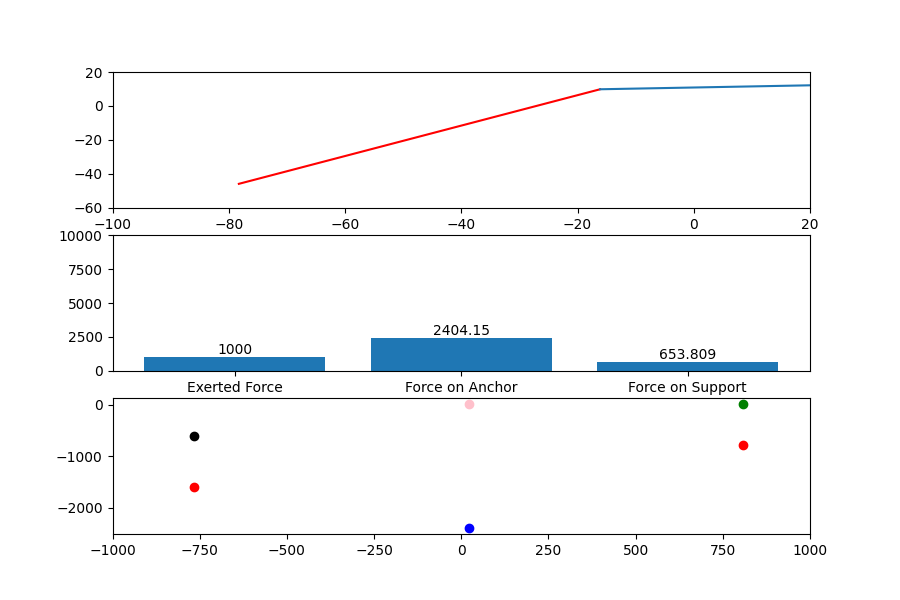

No such comm: 6954720aeee147618b883c347c2afa57


In [83]:
# Checking the anchor trees
reload(mechanical_computations)
reload(geometry_operations)

fig, (ax, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 6)) # two rows, one column

def plot_anchors_hold(index, force):
    sample_cable_road = cable_road_computation.compute_initial_cable_road(line_gdf.iloc[index].geometry,height_gdf)
    sample_cable_road.s_current_tension = force
    mechanical_computations.check_if_anchor_trees_hold_and_plot(sample_cable_road,line_gdf.iloc[index].max_supported_force, line_gdf.iloc[index].possible_anchor_triples, height_gdf, ax, ax2, ax3)

    fig.canvas.draw()

interact(plot_anchors_hold, index=IntSlider(min=0, max=len(line_gdf), step=1, value=10), force=FloatSlider(min=1000, max=10000, step=100, value=1000));


#### Resulting Force on Support per Angle and Incoming Force

In [192]:
unloaded_tangent_line_x = [0, 10000]
unloaded_tangent_line_y = [0, 0]
loaded_tangent_line_x = [0, 10000]
loaded_tangent_line_y = [0, 0]
force_on_support_x = [0, 0]
force_on_support_y = [0, 0]

fig = go.FigureWidget()
bar = fig.add_scatter(x=[*unloaded_tangent_line_x,*loaded_tangent_line_x,*force_on_support_x],
                      y=[*unloaded_tangent_line_y,*loaded_tangent_line_y,*force_on_support_y])
# fig.layout = dict(yaxis=dict(range=[0,1]), height=600)

fig.update_layout(title='Resulting Force per Angle',scene = dict(
                    xaxis_title='Force Vector Y',
                    yaxis_title='Force Vector X'),
                    yaxis=dict(range=[-5000, 10]),
                    xaxis=dict(range=[-10,10000]))

@interact(force=(0, 10000, 100), angle=(0, 90, 1))
def update(force=1000, angle=0):
    # with fig.update():
    res = mechanical_computations.parallelverschiebung(force, angle)
    loaded_tangent_line_y=[0, -res]
    loaded_tangent_line_x=[0, force]
    force_on_support_x = [0, 0]
    force_on_support_y = [0, -res]
    fig.data[0].x=[*unloaded_tangent_line_x,*loaded_tangent_line_x,*force_on_support_x]
    fig.data[0].y=[*unloaded_tangent_line_y,*loaded_tangent_line_y,*force_on_support_y]

# fig.write_html("Resulting_Force_per_Angle.html",full_html=True)
fig

interactive(children=(IntSlider(value=1000, description='force', max=10000, step=100), IntSlider(value=0, desc…

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': 'cee4f0bc-0180-4737-99a9-fc01f9c05c57',
              'x': [0, 10000, 0, 1000, 0, 0],
              'y': [0, 0, 0, 0, 0, 0]}],
    'layout': {'scene': {'xaxis': {'title': {'text': 'Force Vector Y'}}, 'yaxis': {'title': {'text': 'Force Vector X'}}},
               'template': '...',
               'title': {'text': 'Resulting Force per Angle'},
               'xaxis': {'range': [-10, 10000]},
               'yaxis': {'range': [-5000, 10]}}
})

#### Surface Plots of Functions

In [108]:
import plotly.graph_objects as go

x = np.arange(1,10,1)
y = np.arange(1,30,1)
X, Y = np.meshgrid(x, y)
Z = mechanical_computations.euler_knicklast(X,Y)

fig = go.Figure(data=[go.Surface(z=Z)])

fig.update_layout(title='Resulting Force Knicklast',scene = dict(
                    xaxis_title='Tree Diameter',
                    yaxis_title='Height of Attachment',
                    zaxis_title='Maximum Force'))
fig.show()
fig.write_html("02_Figures/Resulting Force Knicklast.html")

In [106]:
y = np.arange(1,90,1)
x = np.arange(1,5000,10)
X, Y = np.meshgrid(x, y)
Z = mechanical_computations.parallelverschiebung(X,Y)


fig = go.Figure(data=[go.Surface(z=Z)])

fig.update_layout(title='Resulting Force Parallelverschiebung',scene = dict(
                    xaxis_title='Force from Cable',
                    yaxis_title='Angle',
                    zaxis_title='Force on Support'))
fig.show()
fig.write_html("02_Figures/Resulting Force Parallelverschiebung.html")